In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

In [0]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
# read dataset from file
df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Data Science Full.xlsx", index_col="Date", parse_dates=True)
df = df.sort_index(ascending=True)
df = df[["Shipment","Order","Revenue"]]

In [0]:
# normalize data into 0 to 1 using MinMaxScaler
scaler = MinMaxScaler()

df_transformed = scaler.fit_transform(df)

In [0]:
# choose a number of time steps
n_steps_in, n_steps_out = 120, 90

# split into samples
X, y = split_sequence(df_transformed, n_steps_in, n_steps_out)

n_features, n_neurons = df.columns.size, 100
n_epochs = [100,200,300,400,500]

# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

In [10]:
predictions = np.zeros((n_steps_out,len(n_epochs)),"float32")

for n in range(len(n_epochs)):

  # define model
  model = Sequential()
  model.add((LSTM(n_neurons, activation='tanh', input_shape=(n_steps_in, n_features))))
  model.add(RepeatVector(n_steps_out))
  model.add((LSTM(n_neurons, activation='tanh', return_sequences=True)))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')

  # fit model
  model.fit(X, y, epochs=n_epochs[n], verbose=1)

  # test prediction
  future_X = df_transformed[-(n_steps_in+1):-1].reshape((1,n_steps_in, n_features))
  future_Y = model.predict(future_X)
  future_Y = scaler.inverse_transform(future_Y[0])

  predictions[:,n] = future_Y[:,n_features-1]

Epoch 1/100
17/17 [==============================] - 0s 15ms/step - loss: 0.1512
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0910
Epoch 3/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0819
Epoch 4/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0804
Epoch 5/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0799
Epoch 6/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0797
Epoch 7/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0794
Epoch 8/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0781
Epoch 9/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0763
Epoch 10/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0735
Epoch 11/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0662
Epoch 12/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0806
Epoch 13/100
17/17 [=====

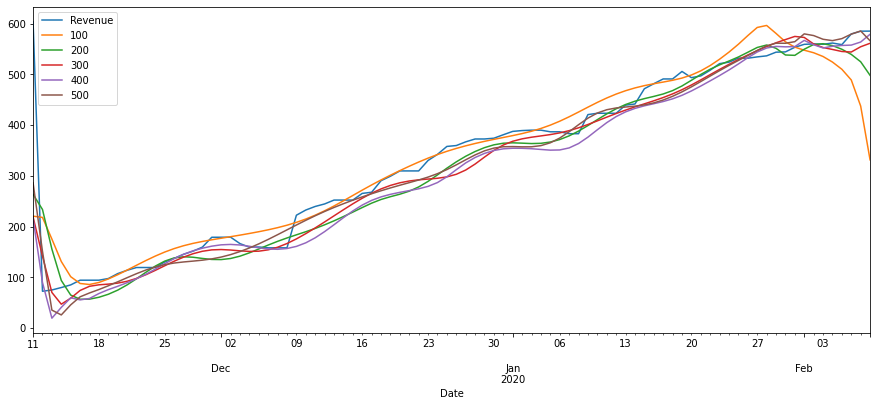

In [11]:
df_future = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Data Science_20200214.xlsx", index_col="Date", parse_dates=True)
df_future = df_future.sort_index(ascending=True)
df_future = df_future[["Revenue"]]

df_future = df_future[-(n_steps_out):]
df_future["100"] = predictions[:,0]
df_future["200"] = predictions[:,1]
df_future["300"] = predictions[:,2]
df_future["400"] = predictions[:,3]
df_future["500"] = predictions[:,4]
df_future.plot(figsize=(15,6))

In [12]:
columns = ["100","200","300","400","500"]
for n in range(len(columns)):
  testScore = math.sqrt(mean_squared_error(df_future["Revenue"].iloc[3:], df_future[columns[n]].iloc[3:]))
  print('Test Score (epochs=%s) : %.2f RMSE' % (columns[n],testScore))

  Final_Revenue_Error = 100*abs(df_future["Revenue"].iloc[3:].max() - df_future[columns[n]].iloc[3:].max())/ df_future["Revenue"].iloc[3:].max()
  print('Final Revenue Error (epochs=%s): %.2f%% \n' % (columns[n],Final_Revenue_Error))

Test Score (epochs=100) : 39.27 RMSE
Final Revenue Error (epochs=100): 1.90% 

Test Score (epochs=200) : 27.25 RMSE
Final Revenue Error (epochs=200): 4.24% 

Test Score (epochs=300) : 23.65 RMSE
Final Revenue Error (epochs=300): 1.79% 

Test Score (epochs=400) : 29.76 RMSE
Final Revenue Error (epochs=400): 1.06% 

Test Score (epochs=500) : 22.82 RMSE
Final Revenue Error (epochs=500): 0.04% 



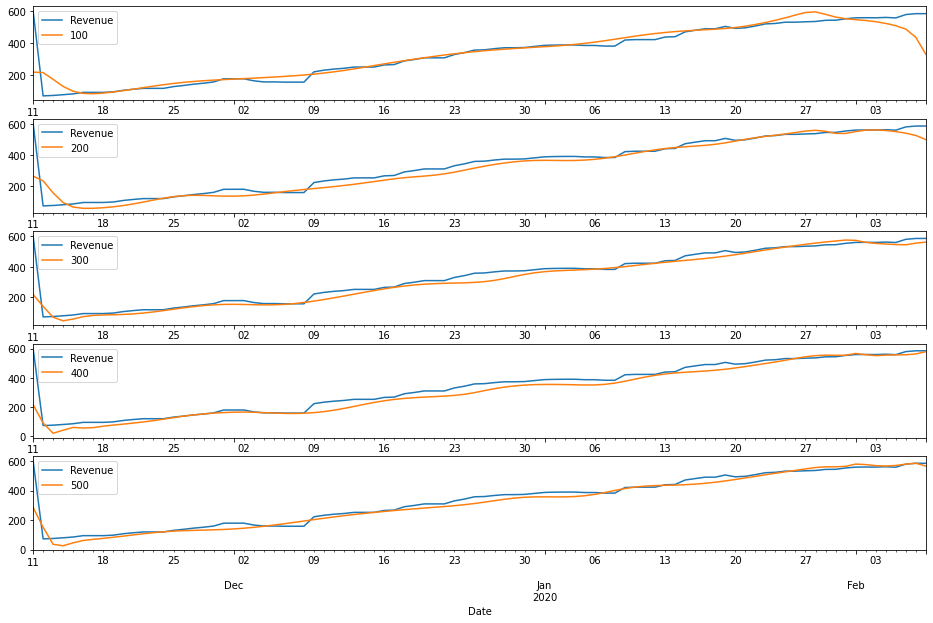

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(16,10))

df_future[['Revenue','100']].plot(ax=axes[0])
df_future[['Revenue','200']].plot(ax=axes[1])
df_future[['Revenue','300']].plot(ax=axes[2])
df_future[['Revenue','400']].plot(ax=axes[3])
df_future[['Revenue','500']].plot(ax=axes[4])